LOADING AND PREPROCESSING DATA


/tmp/ipykernel_218/3712129718.py:58: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'latitude' ('latitude',) The recommendation is to set join explicitly for this case.
  ds_merged = xr.merge([


Merged dataset shape: FrozenMappingWarningOnValuesAccess({'latitude': 141, 'time': 713, 'longitude': 281})

Sample shapes: X_train=(20444436, 5), y_train=(20444436,)

Class imbalance: 99.1:1 (neg:pos)
Lightning pixels: 1.00%

HYPERPARAMETER SEARCH
Using 100,000 / 20,444,436 samples for search
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END activation_fn=ReLU, dropout=0.2, learning_rate=0.0005, minibatches=256, n_epochs=100, n_layers=4, n_neurons=256; total time=  53.1s
[CV] END activation_fn=ReLU, dropout=0.2, learning_rate=0.0005, minibatches=256, n_epochs=100, n_layers=4, n_neurons=256; total time=  29.8s
[CV] END activation_fn=Tanh, dropout=0.2, learning_rate=0.0003, minibatches=256, n_epochs=50, n_layers=3, n_neurons=256; total time= 1.1min
[CV] END activation_fn=Tanh, dropout=0.2, learning_rate=0.0003, minibatches=256, n_epochs=50, n_layers=3, n_neurons=256; total time= 1.1min
[CV] END activation_fn=Tanh, dropout=0.3, learning_rate=0.0005, minibatches=256, n_

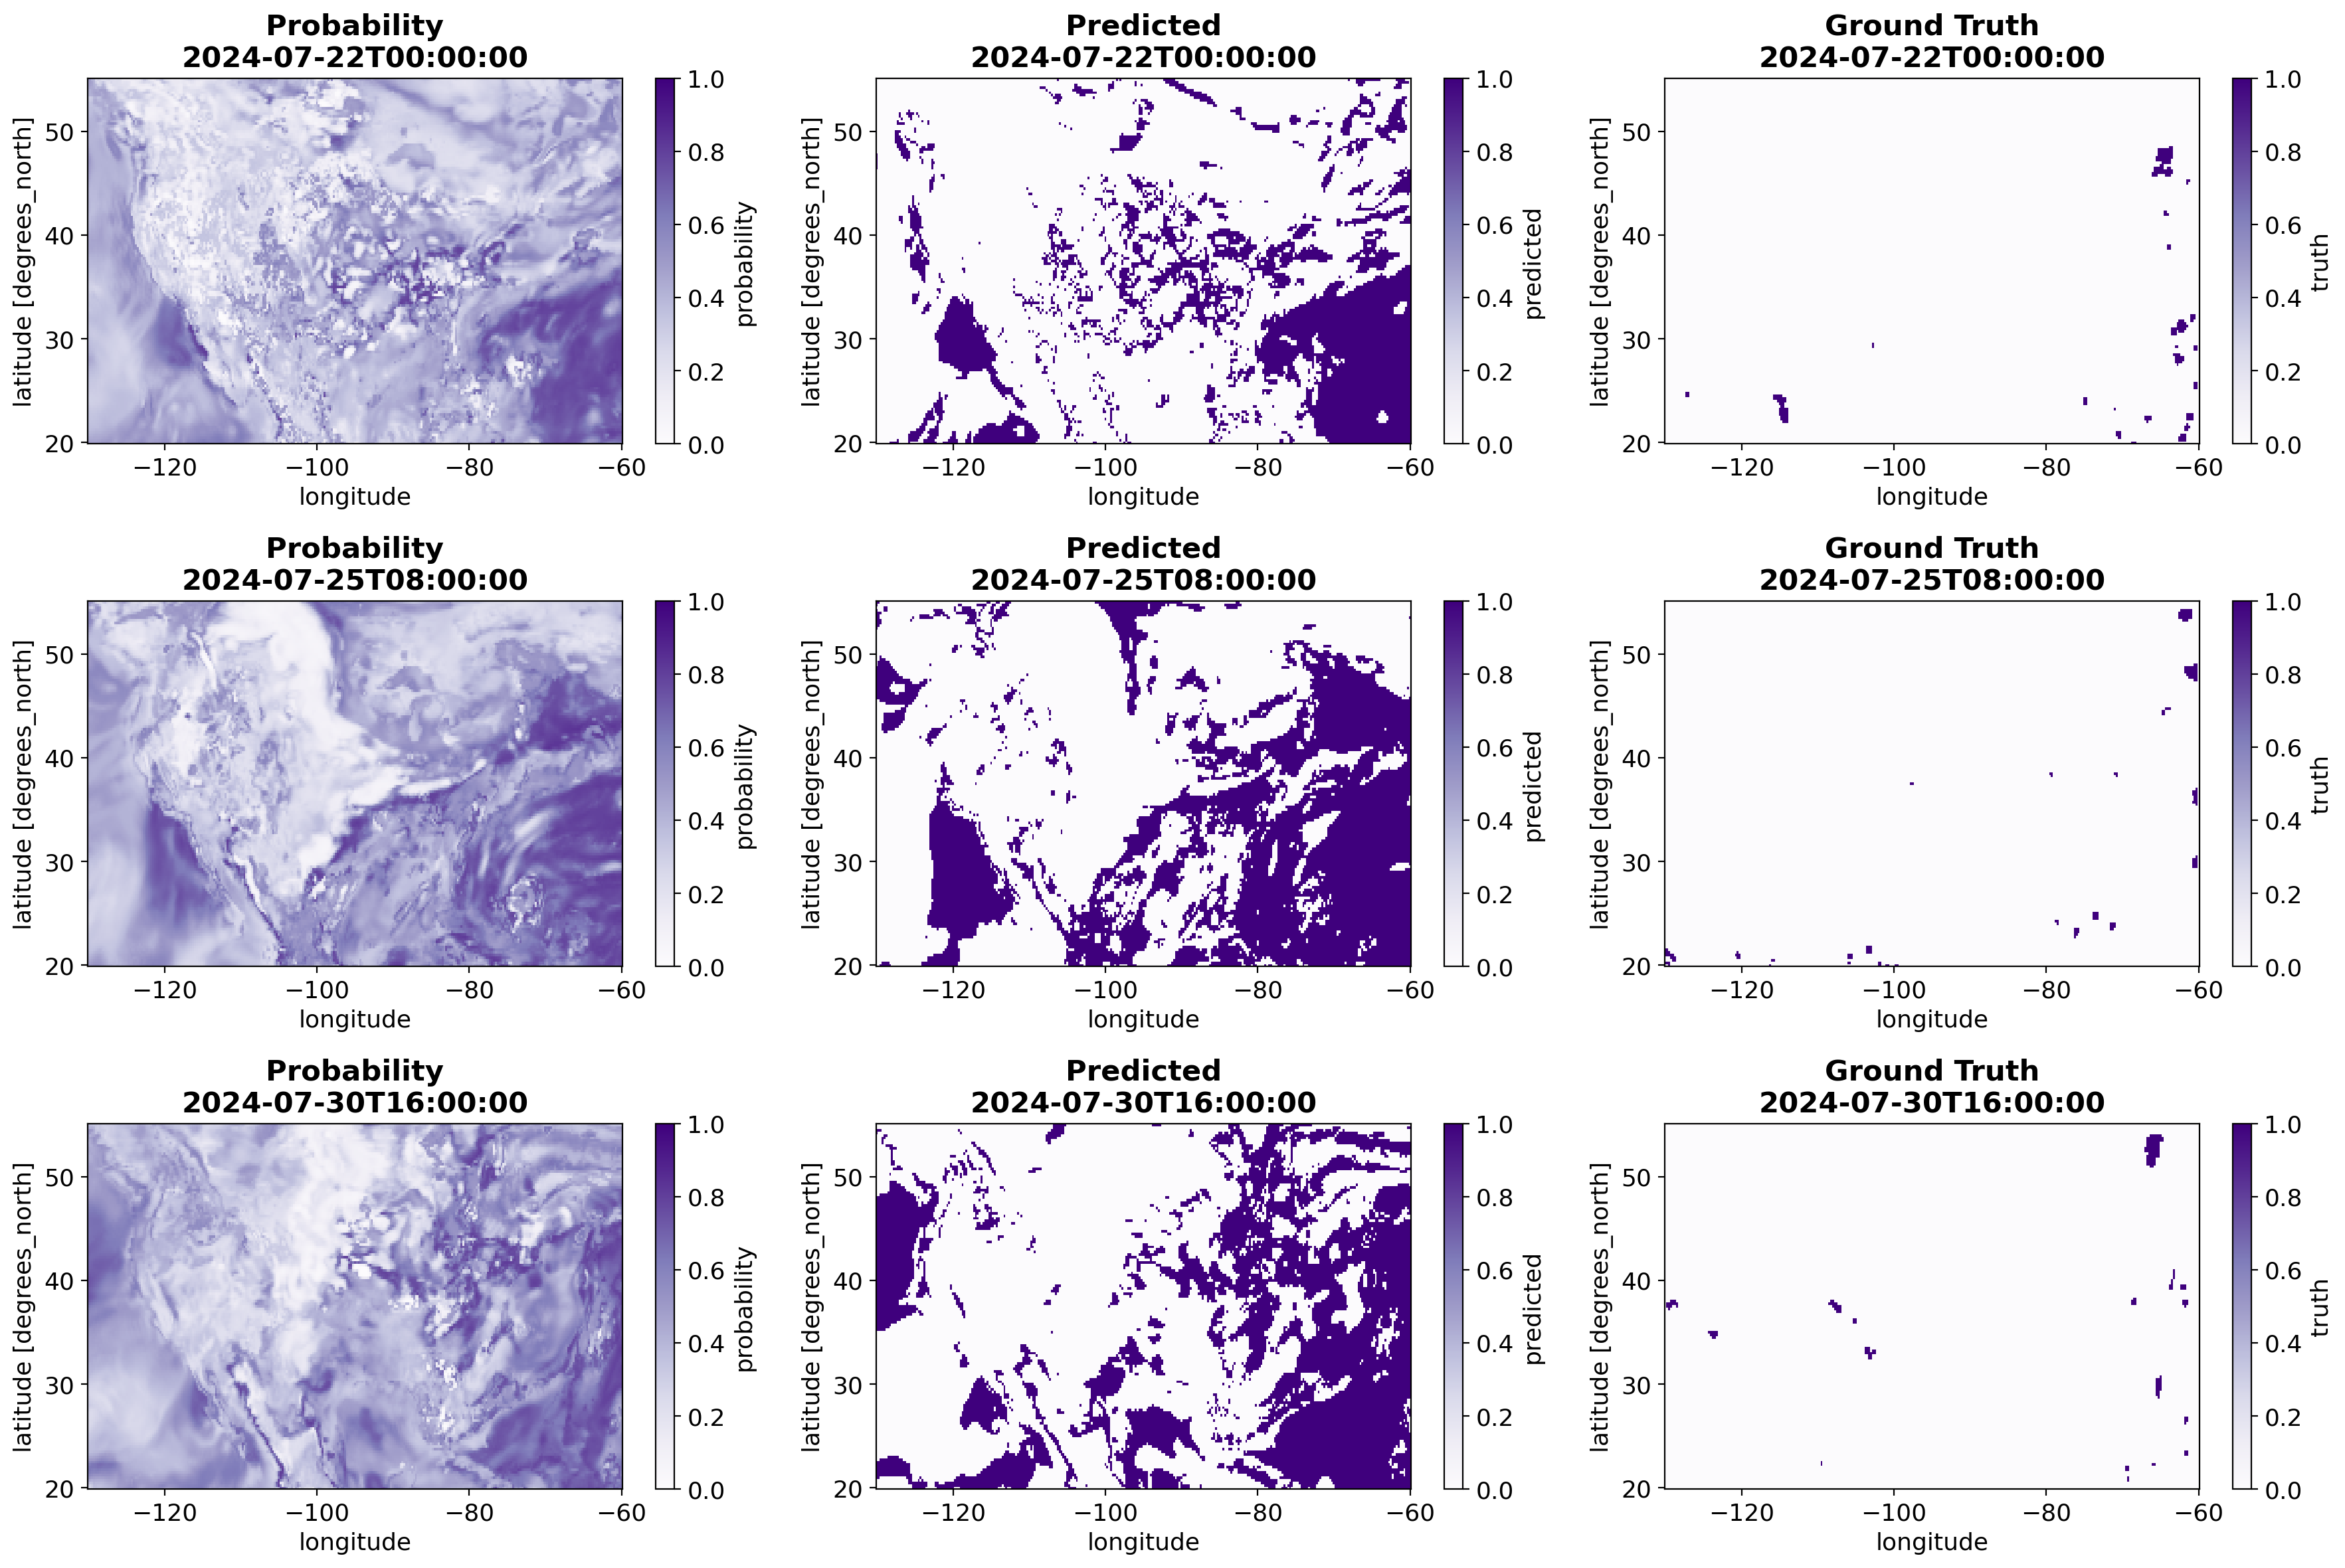

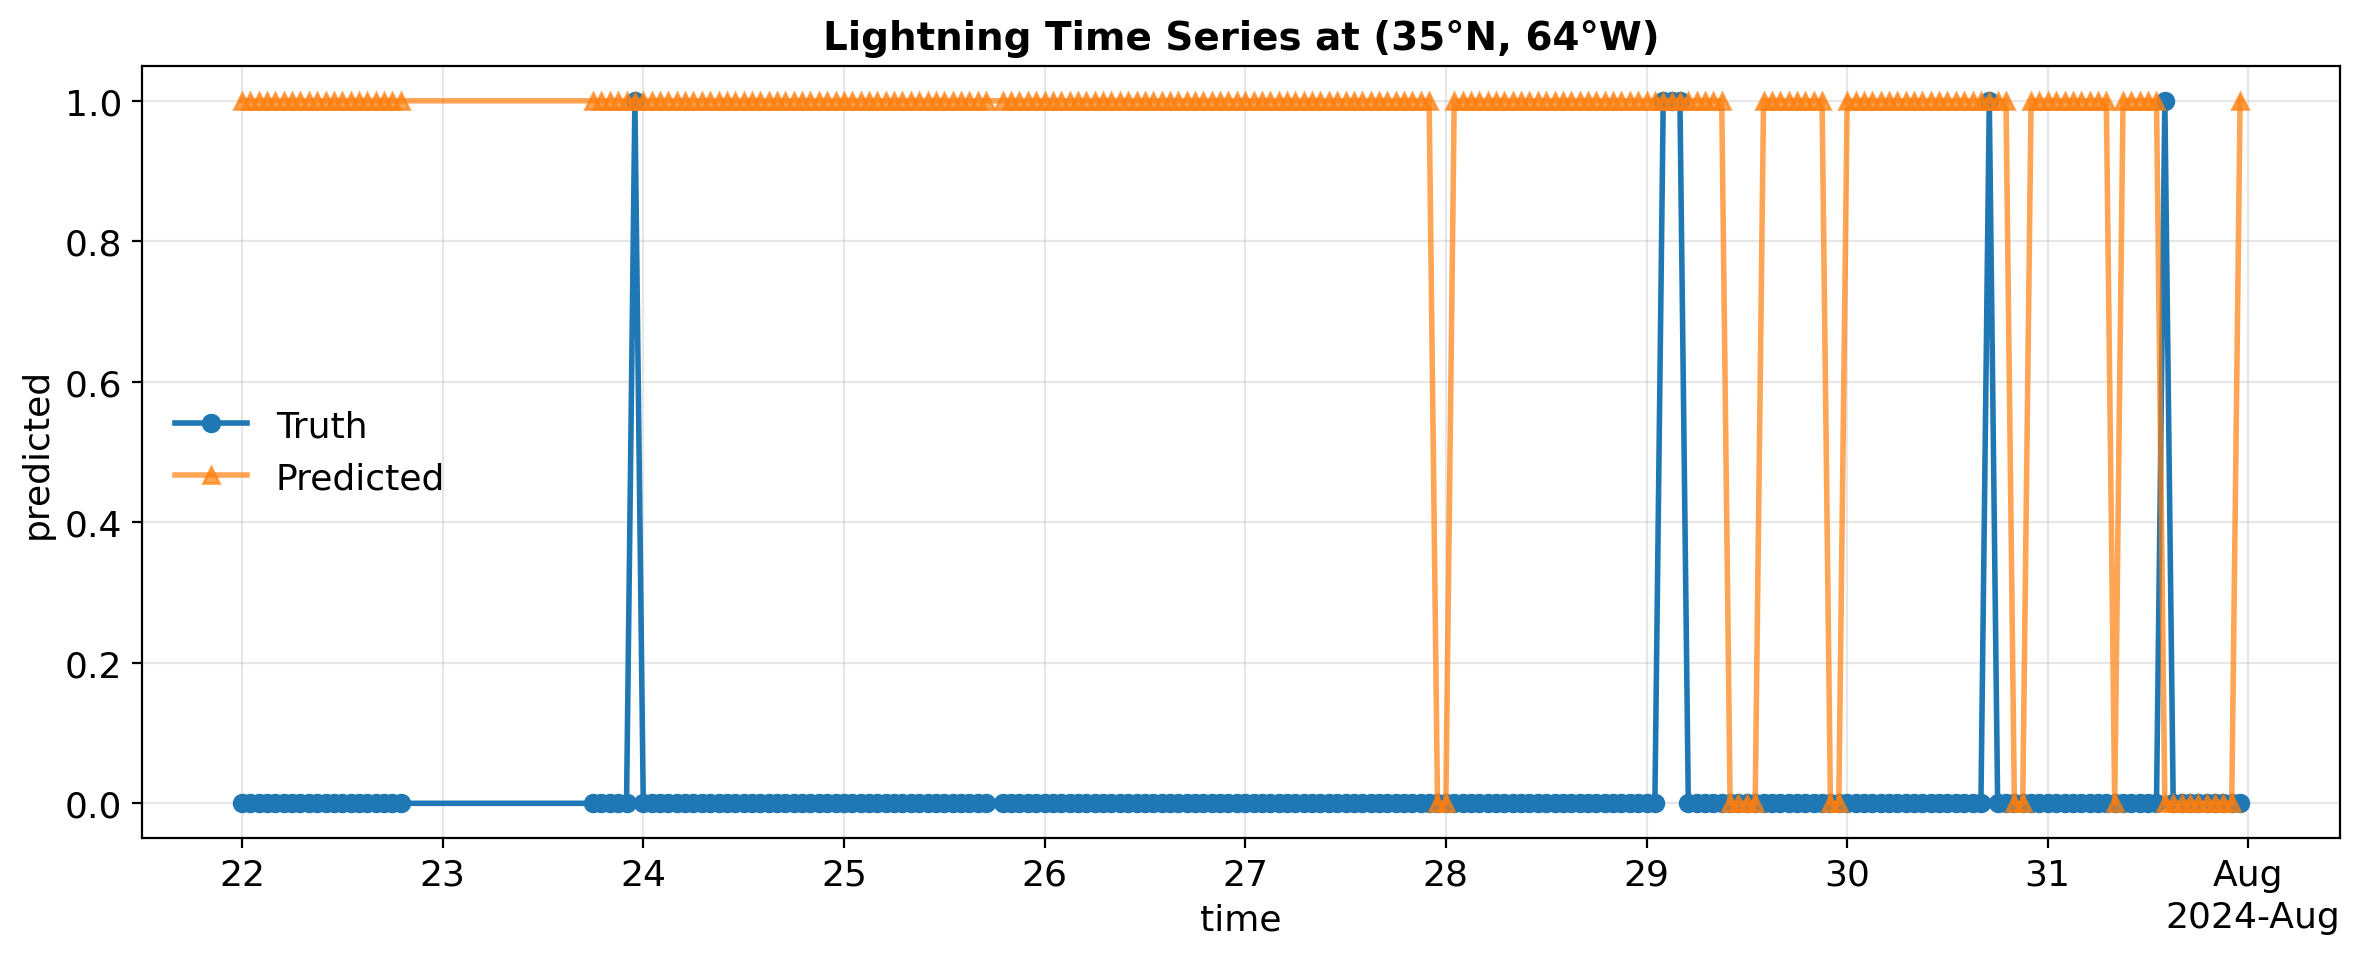

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import time

import torch
import torch.nn as nn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from utils import make_dir, plot_history

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== DATA LOADING =====
print("="*60)
print("LOADING AND PREPROCESSING DATA")
print("="*60)

store1 = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
predictor_vars = [
    'convective_available_potential_energy',
    'total_precipitation',
    '2m_temperature',
    'total_column_water_vapour',
    'vertical_velocity'
]

ds1 = xr.open_dataset(store1, engine='zarr', chunks={})[predictor_vars]

# Select region and time
ds_july = ds1.sel(
    time=slice('2024-07-01', '2024-07-31T23:00:00'),
    latitude=slice(55, 20),
    longitude=slice(230, 300),
    level=500
)

# Align coordinates with lightning data
ds_era5 = ds_july.assign_coords(longitude=(ds_july.longitude - 360).values)

# Merge with lightning
lightning = xr.open_dataset('lightning_july2024_hourly.nc')
common_times = pd.DatetimeIndex(
    sorted(set(ds_era5.time.values) & set(lightning.time.values))
)
ds_merged = xr.merge([
    ds_era5.sel(time=common_times),
    lightning.sel(time=common_times)
])

print(f"Merged dataset shape: {ds_merged.dims}")

# ===== UTILITY: CONVERT TO PIXEL SAMPLES =====

def make_pixel_samples(ds, predictor_vars, target_var='lightning_density'):
    """Convert xarray dataset to pixel-wise samples for sklearn"""
    X = ds[predictor_vars].to_array(dim='feature').transpose(
        'time', 'latitude', 'longitude', 'feature'
    )
    X_flat = X.to_numpy().reshape(-1, len(predictor_vars)).astype(np.float32)
    y_flat = ds[target_var].to_numpy().reshape(-1).astype(np.float32)
    return X_flat, y_flat

# Split train/test
train_xr = ds_merged.sel(time=slice('2024-07-01', '2024-07-22'))
test_xr = ds_merged.sel(time=slice('2024-07-22', '2024-07-31'))

X_train, y_train = make_pixel_samples(train_xr, predictor_vars)
X_test, y_test = make_pixel_samples(test_xr, predictor_vars)

print(f"\nSample shapes: X_train={X_train.shape}, y_train={y_train.shape}")

# Standardize
mean = X_train.mean(axis=0, keepdims=True)
std = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Binary classification
y_train_binary = (y_train > 0).astype(np.int32)
y_test_binary = (y_test > 0).astype(np.int32)

# Class weights
pos_weight = float((y_train_binary == 0).sum() / max((y_train_binary == 1).sum(), 1))
print(f"\nClass imbalance: {pos_weight:.1f}:1 (neg:pos)")
print(f"Lightning pixels: {100 * y_train_binary.mean():.2f}%")

# ===== SKLEARN-COMPATIBLE PYTORCH CLASSIFIER =====

class PytorchNNClassifier(BaseEstimator, ClassifierMixin):
    """Lightning prediction model with sklearn interface"""
    
    def __init__(self, n_neurons=256, activation_fn="ReLU", n_layers=4,
                 dropout=0.2, learning_rate=5e-4, minibatches=128,
                 n_epochs=100, pos_weight=1.0, device="cpu", patience=15,
                 val_split=0.2, random_state=42, threshold=0.5,
                 weight_decay=1e-5, verbose=0):
        self.n_neurons = n_neurons
        self.activation_fn = activation_fn
        self.n_layers = n_layers
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.minibatches = minibatches
        self.n_epochs = n_epochs
        self.pos_weight = pos_weight
        self.device = device
        self.patience = patience
        self.val_split = val_split
        self.random_state = random_state
        self.threshold = threshold
        self.weight_decay = weight_decay
        self.verbose = verbose
        
        self.model_ = None
        self.input_dim_ = None
        self.best_val_f1_ = None
        self.classes_ = np.array([0, 1])
    
    def _create_model(self):
        """Build neural network"""
        layers = [
            nn.Linear(self.input_dim_, self.n_neurons),
            nn.BatchNorm1d(self.n_neurons),
            getattr(nn, self.activation_fn)(),
            nn.Dropout(self.dropout)
        ]
        
        for _ in range(self.n_layers - 1):
            layers.extend([
                nn.Linear(self.n_neurons, self.n_neurons),
                nn.BatchNorm1d(self.n_neurons),
                getattr(nn, self.activation_fn)(),
                nn.Dropout(self.dropout)
            ])
        
        layers.append(nn.Linear(self.n_neurons, 1))
        return nn.Sequential(*layers)
    
    def fit(self, X, y):
        """Train model"""
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1)
        
        self.input_dim_ = X.shape[1]
        self.model_ = self._create_model().to(self.device)
        
        # Train/val split
        strat = y if np.unique(y).size == 2 else None
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=self.val_split, random_state=self.random_state, stratify=strat
        )
        
        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.from_numpy(X_tr),
                torch.from_numpy(y_tr.reshape(-1, 1))
            ),
            batch_size=self.minibatches,
            shuffle=True
        )
        
        val_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.from_numpy(X_val),
                torch.from_numpy(y_val.reshape(-1, 1))
            ),
            batch_size=self.minibatches,
            shuffle=False
        )
        
        optimizer = torch.optim.Adam(
            self.model_.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        
        criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor([self.pos_weight], device=self.device)
        )
        
        best_val_f1 = -np.inf
        best_state = None
        patience_counter = 0
        
        for epoch in range(self.n_epochs):
            # Training
            self.model_.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                loss = criterion(
                    self.model_(batch_X.to(self.device)),
                    batch_y.to(self.device)
                )
                loss.backward()
                optimizer.step()
            
            # Validation
            self.model_.eval()
            val_preds, val_true = [], []
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    logits = self.model_(batch_X.to(self.device))
                    probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
                    val_preds.append((probs >= self.threshold).astype(int))
                    val_true.append(batch_y.numpy().reshape(-1).astype(int))
            
            val_f1 = f1_score(
                np.concatenate(val_true),
                np.concatenate(val_preds),
                zero_division=0
            )
            
            if self.verbose and (epoch + 1) % 10 == 0:
                print(f"  Epoch {epoch+1}: val_f1={val_f1:.4f}")
            
            # Early stopping
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_state = {k: v.cpu().clone() for k, v in self.model_.state_dict().items()}
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    break
        
        if best_state:
            self.model_.load_state_dict(best_state)
        
        self.best_val_f1_ = best_val_f1
        return self
    
    def predict_proba(self, X):
        """Predict probabilities"""
        self.model_.eval()
        with torch.no_grad():
            probs = torch.sigmoid(
                self.model_(torch.from_numpy(np.asarray(X, dtype=np.float32)).to(self.device))
            ).cpu().numpy().reshape(-1, 1)
        return np.hstack([1 - probs, probs])
    
    def predict(self, X):
        """Predict classes"""
        return (self.predict_proba(X)[:, 1] >= self.threshold).astype(int)
    
    def score(self, X, y):
        """F1 score"""
        return f1_score(np.asarray(y).reshape(-1), self.predict(X), zero_division=0)

# ===== HYPERPARAMETER SEARCH =====

print("\n" + "="*60)
print("HYPERPARAMETER SEARCH")
print("="*60)

# Subsample for speed
n_subset = min(100000, len(X_train))
X_subset, _, y_subset, _ = train_test_split(
    X_train, y_train_binary,
    train_size=n_subset / len(X_train),
    stratify=y_train_binary,
    random_state=42
)

print(f"Using {len(X_subset):,} / {len(X_train):,} samples for search")

# Search space
param_grid = {
    'n_neurons': [128, 256],
    'activation_fn': ['ReLU', 'Tanh'],
    'n_epochs': [50, 100],
    'learning_rate': [3e-4, 5e-4, 1e-3],
    'minibatches': [128, 256],
    'n_layers': [3, 4, 5],
    'dropout': [0.2, 0.3]
}

# Search
search = RandomizedSearchCV(
    PytorchNNClassifier(pos_weight=pos_weight, device=device, patience=10, verbose=0),
    param_grid,
    n_iter=10,
    cv=2,
    scoring=make_scorer(f1_score, zero_division=0),
    random_state=42,
    verbose=2
)

start = time.time()
search.fit(X_subset, y_subset)
print(f"\nSearch completed in {(time.time() - start)/60:.1f} minutes")

best_params = search.best_params_
print(f"\nBest F1: {search.best_score_:.4f}")
print("Best params:", best_params)

# Save results
pd.DataFrame(search.cv_results_).to_csv('search_results.csv', index=False)

# ===== TRAIN FINAL MODEL =====

print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)

# Option 1: Subsample final training (FASTER - recommended for testing)
USE_SUBSET_FOR_FINAL = True  # Set to False to use all data
FINAL_SUBSET_SIZE = 200000  # Use 200k samples for final training

if USE_SUBSET_FOR_FINAL and len(X_train) > FINAL_SUBSET_SIZE:
    print(f"Subsampling final training: {FINAL_SUBSET_SIZE:,} / {len(X_train):,} samples")
    X_train_final, _, y_train_final, _ = train_test_split(
        X_train, y_train_binary,
        train_size=FINAL_SUBSET_SIZE / len(X_train),
        stratify=y_train_binary,
        random_state=42
    )
else:
    print(f"Using full training set: {len(X_train):,} samples")
    X_train_final = X_train
    y_train_final = y_train_binary

final_model = PytorchNNClassifier(
    **best_params,
    pos_weight=pos_weight,
    device=device,
    patience=20,
    verbose=1
)

start_final = time.time()
final_model.fit(X_train_final, y_train_final)
final_time = time.time() - start_final

print(f"\nFinal training completed in {final_time/60:.1f} minutes")
print(f"Final model best val F1: {final_model.best_val_f1_:.4f}")

# Save
model_path = os.path.join(os.getcwd(), 'saved_model')
make_dir(model_path)
torch.save(final_model.model_.state_dict(), os.path.join(model_path, 'optimized_model.pth'))
print(f"Model saved to {model_path}")

# ===== EVALUATION =====

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# Metrics
metrics = {
    'Accuracy': accuracy_score(y_test_binary, y_pred),
    'Precision': precision_score(y_test_binary, y_pred, zero_division=0),
    'Recall': recall_score(y_test_binary, y_pred, zero_division=0),
    'F1 Score': f1_score(y_test_binary, y_pred, zero_division=0),
    'AUC-ROC': roc_auc_score(y_test_binary, y_prob)
}

for name, value in metrics.items():
    print(f"  {name}: {value:.4f}")

# ===== VISUALIZATION =====

print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# Reshape for spatial plots
n_times, n_lats, n_lons = len(test_xr.time), len(test_xr.latitude), len(test_xr.longitude)
y_pred_spatial = y_pred.reshape(n_times, n_lats, n_lons)
y_prob_spatial = y_prob.reshape(n_times, n_lats, n_lons)
y_true_spatial = y_test_binary.reshape(n_times, n_lats, n_lons)

# Create xarray for easy plotting
pred_xr = xr.Dataset({
    'predicted': (['time', 'latitude', 'longitude'], y_pred_spatial),
    'probability': (['time', 'latitude', 'longitude'], y_prob_spatial),
    'truth': (['time', 'latitude', 'longitude'], y_true_spatial)
}, coords=test_xr.coords)

# Spatial comparison
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
times = ['2024-07-22T00:00:00', '2024-07-25T08:00:00', '2024-07-30T16:00:00']

for i, t in enumerate(times):
    pred_xr.probability.sel(time=t).plot(ax=axes[i, 0], vmin=0, vmax=1, cmap='Purples')
    axes[i, 0].set_title(f'Probability\n{t}', fontweight='bold')
    
    pred_xr.predicted.sel(time=t).plot(ax=axes[i, 1], vmin=0, vmax=1, cmap='Purples')
    axes[i, 1].set_title(f'Predicted\n{t}', fontweight='bold')
    
    pred_xr.truth.sel(time=t).plot(ax=axes[i, 2], vmin=0, vmax=1, cmap='Purples')
    axes[i, 2].set_title(f'Ground Truth\n{t}', fontweight='bold')

plt.tight_layout()
plt.savefig('predictions_spatial.png', dpi=150, bbox_inches='tight')
print("Saved: predictions_spatial.png")

# Time series
fig, ax = plt.subplots(figsize=(12, 5))
pred_xr.sel(latitude=35, longitude=-64, method='nearest').truth.plot(
    ax=ax, marker='o', label='Truth', linewidth=2
)
pred_xr.sel(latitude=35, longitude=-64, method='nearest').predicted.plot(
    ax=ax, marker='^', label='Predicted', linewidth=2, alpha=0.7
)
ax.legend()
ax.set_title('Lightning Time Series at (35°N, 64°W)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predictions_timeseries.png', dpi=150, bbox_inches='tight')
print("Saved: predictions_timeseries.png")

print("\n" + "="*60)
print("COMPLETE!")
print("="*60)